In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import Tensor, nn
from torchvision import datasets, transforms
from torch.cuda import is_available
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import resize

/home/jupyter-tfg2324dm/.conda/envs/envDM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyperparameters

In [2]:
# training hyperparameters
batch_size = 64
n_epoch = 100
learning_rate = 1e-3
# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 7 # label vector is of size 5
height = 64 # 64x64 image
lowres_height = 64
save_dir = './weights/'
# diffusion hyperparameters
timesteps = 1000

# Diffusion Model


## Class

In [20]:
class Diffusion_Models():
  # return beta_sqrt, alpha, alpha_sqrt, gamma, gamma_sqrt fr noise and denoise image
  def __init__(self, timesteps, beta1=1e-4, beta2=0.02):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    scale = 1000 / timesteps
    beta1 = scale * beta1
    beta2 = scale * beta2
    beta = torch.linspace(beta1**0.5, beta2**0.5, timesteps + 1, device=self.device) **2
    alpha = 1 - beta
    one_by_sqrt_alpha = 1./alpha.sqrt()
    gamma = torch.cumprod(alpha, axis=0)
    gamma[0] = 1
    sqrt_one_minus_gamma = (1. - gamma).sqrt()
    beta_by_sqrt_one_minus_gamma = beta/sqrt_one_minus_gamma
    self.noise_schedule_dict = {'alpha':alpha, 'sqrt_alpha':alpha.sqrt(),
                   'beta':beta, 'sqrt_beta':beta.sqrt(),
                   'gamma':gamma, 'sqrt_gamma':gamma.sqrt(),
                   'one_by_sqrt_alpha':one_by_sqrt_alpha,
                   'sqrt_one_minus_gamma':sqrt_one_minus_gamma,
                   'beta_by_sqrt_one_minus_gamma':beta_by_sqrt_one_minus_gamma}
    self.timesteps = timesteps

  def show_noise_schedule(self):
    rows = 5
    cols = 2
    plt.figure(figsize=(16,16))
    for i, schedule in enumerate(self.noise_schedule_dict):
      plt.subplot(rows, cols, i + 1)
      plt.title(schedule)
      curr_schedule = self.noise_schedule_dict[schedule]
      plt.plot(curr_schedule)

  def show_noise_schedule2(self):
    for i, schedule in enumerate(self.noise_schedule_dict):
      plt.figure(figsize=(4,4))
      plt.title(schedule)
      curr_schedule = self.noise_schedule_dict[schedule]
      plt.plot(curr_schedule)

  def noise_image(self, x_0, time, noise=None):
    if noise is None:
      noise = torch.randn_like(x_0)
    img = self.noise_schedule_dict['sqrt_gamma'].to(self.device)[time, None, None, None] * x_0.to(self.device) + (self.noise_schedule_dict['sqrt_one_minus_gamma'].to(self.device)[time, None, None, None]) * noise.to(self.device)
    return img

  def denoise_image(self, x_t, time, noise):
    if noise is None:
      noise = torch.randn_like(x_0)
    img = (x_t.to(self.device) - (self.noise_schedule_dict['sqrt_one_minus_gamma'].to(self.device)[time, None, None, None]) * noise.to(self.device))/self.noise_schedule_dict['sqrt_gamma'].to(self.device)[time, None, None, None]
    return img

  def unorm(self, img):
    mean_ = 0.7069
    std_ = 0.3487
    img = (img * std_) + mean_
    img = torch.tensor(img)
    img = torch.clamp(img, 0.,1.)
    return img

  def simulate_forward_diffusion(self, time_step, dataset, image=None, num_images=10):
    plt.figure(figsize=(num_images*2, 2))
    if image is None:
      idx = np.random.randint(len(dataset))
      image, curr_label = dataset[idx]
    stepsize = int(time_step/num_images)
    steps = range(0, time_step, stepsize)
    for i, curr_time in enumerate(steps):
      time = torch.Tensor([curr_time]).type(torch.int64)
      img = self.noise_image(image, time).to('cpu')
      img = self.unorm(img)
      plt.subplot(1, num_images + 1, i + 1)
      plt.axis('off')
      plt.title("time: {}".format(curr_time))
      plt.imshow(img[0].permute(1,2,0))

  def denoise_add_noise(self, x_t, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x_t)
    sqrt_beta = self.noise_schedule_dict['sqrt_beta'][t, None, None, None].to(self.device)
    noise = z.to(self.device) * sqrt_beta
    beta_by_sqrt_one_minus_gamma = self.noise_schedule_dict['beta_by_sqrt_one_minus_gamma'][t, None, None, None].to(self.device)
    pred_noise = pred_noise.to(self.device) * beta_by_sqrt_one_minus_gamma
    mean = (x_t - pred_noise) * self.noise_schedule_dict['one_by_sqrt_alpha'][t, None, None, None].to(self.device)
    if t > 1:
      x_t_minus_1 = mean + noise
    else:
      x_t_minus_1 = mean

    return x_t_minus_1
        
        
  # sample with context using standard algorithm
  @torch.no_grad()
  def sample_ddpm_context(self, model, n_sample, lowres_img, save_rate=20, end_timestep = None, samples = None):
    # x_T
    if end_timestep is None:
        end_timestep = timesteps
    # arrays to keep track of generated steps for plotting
    self.intermediate = []
    self.intermediate_time = []
    #lowres_img = torch.cat(lowres_img).view(n_sample, 3, height, height).to(device)
    if samples is None:
        samples = torch.randn(size=(n_sample, 3, height, height)).to(self.device)
    for i in range(end_timestep, 0, -1):
        # reshape time tensor
        t = torch.tensor([(i / timesteps)])[:, None, None, None].to(self.device)
        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else torch.zeros_like(samples)
        eps = model(samples, t, lowres_img)    # predict noise e_(x_t,t, ctx)
        samples = self.denoise_add_noise(samples, i, eps, z=z)
        if i % save_rate==0 or i==timesteps or i<8:
            self.intermediate.append(samples.detach().cpu().numpy())
            self.intermediate_time.append(i)
    self.intermediate = np.stack(self.intermediate)
    return samples

  def draw_samples_process(self):
    cols = len(self.intermediate)
    rows = self.intermediate[0].shape[0]
    plt.figure(figsize=(cols*2, rows*2))
    for i, curr_imgs in enumerate(self.intermediate):
      curr_time = self.intermediate_time[i]
      for j, curr_img in enumerate(curr_imgs):
        curr_img = self.unorm(curr_img)
        curr_img = np.transpose(curr_img, (1, 2, 0))
        plt.subplot(rows, cols, (j*cols) + i + 1)
        plt.axis('off')
        plt.title("time: {}".format(curr_time))
        plt.imshow(curr_img)
        
    plt.savefig('samples_process.png')
        
        
df = Diffusion_Models(timesteps)

# Custom Dataset

In [5]:
class MyDataset(Dataset):
    def __init__(self, filename, transform=None):
        file = np.load(filename, allow_pickle = True)
        self.dataset = file.item()['dataset']
        self.len = file.item()['length']
        self.name = file.item()['name']
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(0.7069,0.3487)
            ])
        else:
            self.transform = transform

    # Return the number of images in the dataset
    def __len__(self):
        return self.len
    
    def getStyle(self):
        img = Image.open("style_.jpg")
        img = img.convert('RGB')
        img = self.transform(img)
        return img
    # Get the image and label at a given index

    def __getitem__(self, idx):
        # Return the image and label as a tuple
        image = self.transform(self.dataset[idx]['img'])
        return image

    # Get the shapes of datas and labels
    def getshapes(self):
        # return shapes of data and labels
        return self.dataset['shape']

In [6]:
# DataSet path
dataset_data_path = './conceptual_captions.npy'
# load dataset
dataset = MyDataset(dataset_data_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)


# Model (SuperRes U-Net)

This model will be train for predict the noise of image

In [7]:
class Block(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, is_res: bool = False) -> None:
    super().__init__()

    # Check if input and output channels are not the same for the residual connection
    self.non_same_channels = in_channels != out_channels

    # Boolean to control if use or not residual connection
    self.is_res = is_res

    # First convolutional layer
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
         nn.BatchNorm2d(out_channels),   # Batch normalization
        nn.ReLU(),   # GELU activation function
        )

    # Second convolutional layer
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
         nn.BatchNorm2d(out_channels),   # Batch normalization
        nn.ReLU(),   # GELU activation function
        )

  def forward(self, x):
    # If using residual connection
    if self.is_res:
      x1 = self.conv1(x)
      x2 = self.conv2(x1)

      # If input and output channels are not the same, apply a 1x1 convolutional layer to match dimensions before adding residual connection
      if self.non_same_channels:
        shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
        x = shortcut(x) + x2
      out = x + x2
    # If not using residual connection, return output of second convolutional layer
    else:
      x1 = self.conv1(x)
      out = self.conv2(x1)
    return out

class UnetUp(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UnetUp, self).__init__()
    # The model consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
    self.model = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
        Block(out_channels, out_channels),
        Block(out_channels, out_channels)
        )

  def forward(self, x, skip):
    # Concatenate the input tensor x with the skip connection tensor along the channel dimension
    x = torch.cat((x, skip), 1)

    # Pass the concatenated tensor through the sequential model and return the output
    x = self.model(x)
    return x


class UnetDown(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UnetDown, self).__init__()
    # Each block consists of two Block layers, followed by a MaxPool2d layer for downsampling
    self.model = nn.Sequential(
        Block(in_channels, out_channels),
        Block(out_channels, out_channels),
        nn.MaxPool2d(2)
        )

  def forward(self, x):
    return self.model(x)

class EmbedFC(nn.Module):
  def __init__(self, input_dim, emb_dim):
    super(EmbedFC, self).__init__()
    #This class defines a generic one layer feed-forward neural network for embedding input data of
    #dimensionality input_dim to an embedding space of dimensionality emb_dim.
    self.input_dim = input_dim
    self.emb_dim = emb_dim
    self.model = nn.Sequential(
        nn.Linear(input_dim, emb_dim),
        nn.ReLU(),
        nn.Linear(emb_dim, emb_dim)
        )

  def forward(self, x):
    # flatten the input tensor
    x = x.view(-1, self.input_dim)
    # apply the model layers to the flattened tensor
    return self.model(x).view(-1, self.emb_dim, 1, 1)

In [8]:
class Unet(nn.Module):
  def __init__(self, in_channels, n_feat=64, height=16):  # cfeat - context features
    super(Unet, self).__init__()
    # number of input channels, number of intermediate feature maps and number of classes
    self.h = height  #assume h == w.

    # Initialize the initial convolutional layer
    self.init_conv = Block(2*in_channels, n_feat, is_res=True) #[b, 64, 64, 64]

    # Initialize the down-sampling path of the U-Net with two levels
    self.down1 = UnetDown(n_feat, n_feat)        # down1 #[b, 64, 32, 32]
    self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[b, 128, 16, 16]
    self.down3 = UnetDown(2*n_feat, 4*n_feat)        # down3 #[b, 256, 8, 8]
    self.down4 = UnetDown(4*n_feat, 8* n_feat)    # down4 #[b, 512, 4, 4]
    self.down5 = UnetDown(8*n_feat, 16* n_feat)    # down4 #[b, 1024, 2, 2]

    # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.ReLU())
    self.to_vec = nn.Sequential(nn.AvgPool2d((2)), nn.ReLU())

    # Embed the timestep and context labels with a one-layer fully connected neural network
    self.timeembed1 = EmbedFC(1, 2*16*n_feat)  # (scale, shift)
    self.timeembed2 = EmbedFC(1, 2*8*n_feat)
    self.timeembed3 = EmbedFC(1, 2*4*n_feat)
    self.timeembed4 = EmbedFC(1, 2*2*n_feat)
    self.timeembed5 = EmbedFC(1, 2*n_feat)

    # Initialize the up-sampling path of the U-Net with three levels
    self.up0 = nn.Sequential(
        nn.ConvTranspose2d(16 * n_feat, 16 * n_feat, 2, 2), # up-sample
        nn.BatchNorm2d(16 * n_feat), # normalize
        nn.ReLU(),
    )                                             # up0 #[b, 1024+1024, 2, 2]
    self.up1 = UnetUp(32 * n_feat, 8 * n_feat)    # up1 #[b, 512+512, 4, 4]
    self.up2 = UnetUp(16 * n_feat, 4 * n_feat)    # up2 #[b, 256+256, 8, 8]
    self.up3 = UnetUp(8 * n_feat, 2 * n_feat)     # up3 #[b, 128+128, 16, 16]
    self.up4 = UnetUp(4 * n_feat, n_feat)         # up4 #[b, 64+64, 32, 32]
    self.up5 = UnetUp(2 * n_feat, n_feat)         # up5 #[b, 64, 64, 64]

    # Initialize the final convolutional layers to map to the same number of channels as the input image
    self.out = nn.Sequential(
        nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
        nn.ReLU(),
        nn.Conv2d(n_feat, in_channels, 3, 1, 1), # map to same number of channels as input
    )

  def forward(self, x, t, lowres):
    """
    x : (batch, n_feat, h, w) : input image
    t : (batch, n_cfeat)      : time step
    c : (batch, n_classes)    : context label
    """
    # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on
    x = torch.cat((x, lowres), dim=1)
    
    # pass the input image through the initial convolutional layer
    x = self.init_conv(x)
    # pass the result through the down-sampling path
    down1 = self.down1(x)
    down2 = self.down2(down1)
    down3 = self.down3(down2)
    down4 = self.down4(down3)
    down5 = self.down5(down4)

    # convert the feature maps to a vector and apply an activation
    hiddenvec = self.to_vec(down5)

    # embed context and timestep with (batch, 2*n_feat, 1,1) for emb1 and (batch, n_feat, 1,1) for emb2
    sc1, sh1 = self.timeembed1(t).chunk(2, dim=1) #(scale, shift)
    sc2, sh2 = self.timeembed2(t).chunk(2, dim=1)
    sc3, sh3 = self.timeembed3(t).chunk(2, dim=1)
    sc4, sh4 = self.timeembed4(t).chunk(2, dim=1)
    sc5, sh5 = self.timeembed5(t).chunk(2, dim=1)
    
    up1 = self.up0(hiddenvec)
    up2 = self.up1(sc1*up1 + sh1, down5)
    up3 = self.up2(sc2*up2 + sh2, down4)  # add and multiply embeddings
    up4 = self.up3(sc3*up3 + sh3, down3)
    up5 = self.up4(sc4*up4 + sh4, down2)  # add and multiply embeddings
    up6 = self.up5(sc5*up5 + sh5, down1)
    out = self.out(torch.cat((up6, x), 1))
    return out

# Training

## optimizer and loss function

In [9]:
model = Unet(in_channels=3, n_feat=n_feat, height=height).to(device)
#model.load_state_dict(torch.load("./weights/model_superres_021.pth", map_location=device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Start training

------------------------------------ epoch 001 (0 steps) ------------------------------------
Max loss: 2.8670825958251953
Min loss: 1.0684986114501953
Mean loss: 1.302033896036182
Std loss: 0.14338355107438291
Total Loss: 1468.6942347288132
saved model at ./weights/model_style_001.pth
------------------------------------ epoch 002 (1128 steps) ------------------------------------
Max loss: 1.524683952331543
Min loss: 1.0528432130813599
Mean loss: 1.2261462621655024
Std loss: 0.06208411286677933
Total Loss: 1383.0929837226868
------------------------------------ epoch 003 (2256 steps) ------------------------------------
Max loss: 1.4396723508834839
Min loss: 1.055408000946045
Mean loss: 1.2100793019676885
Std loss: 0.059422178644241624
Total Loss: 1364.9694526195526
------------------------------------ epoch 004 (3384 steps) ------------------------------------
Max loss: 1.389845609664917
Min loss: 1.013254165649414
Mean loss: 1.1989050359590678
Std loss: 0.06110423398024267
Total Los

KeyboardInterrupt: 

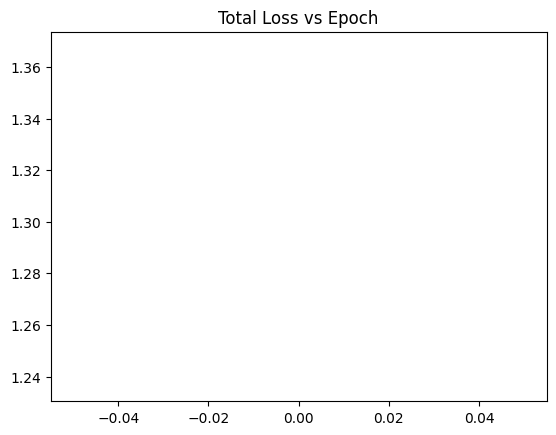

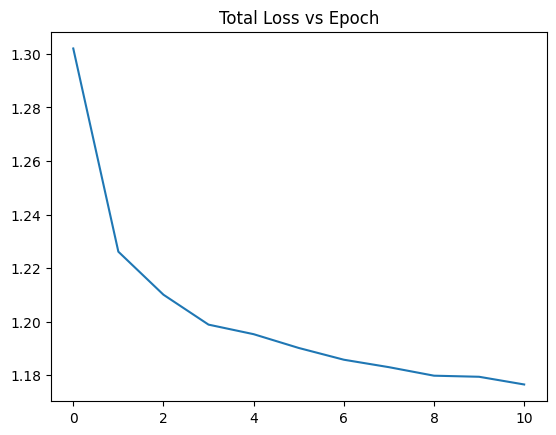

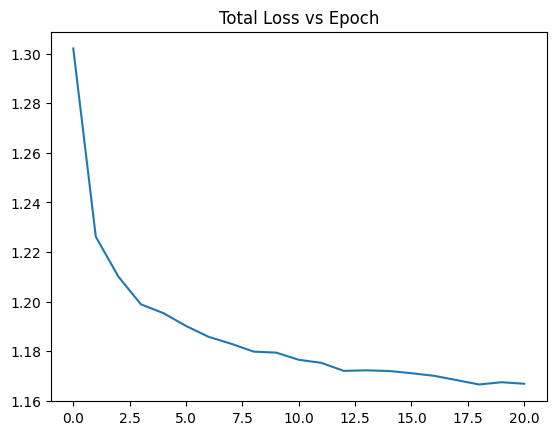

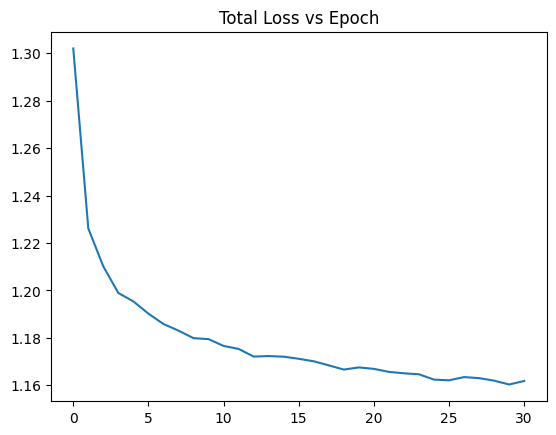

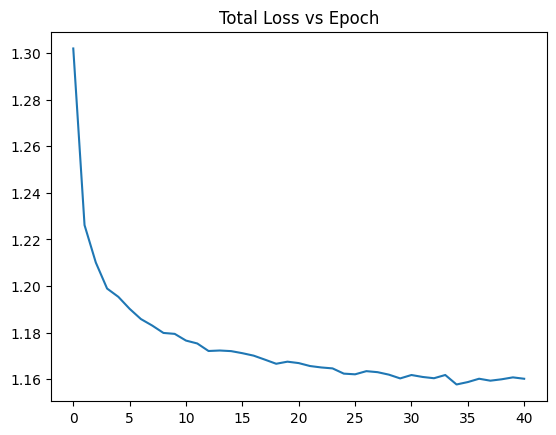

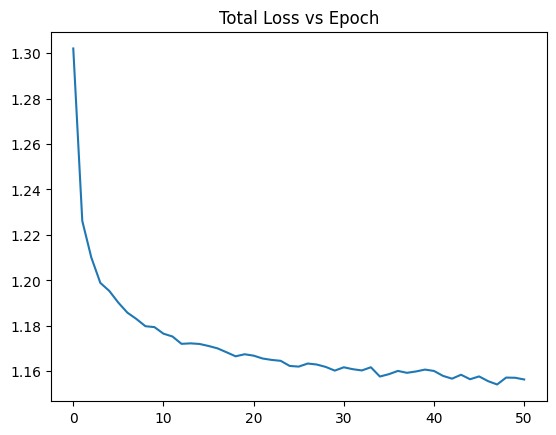

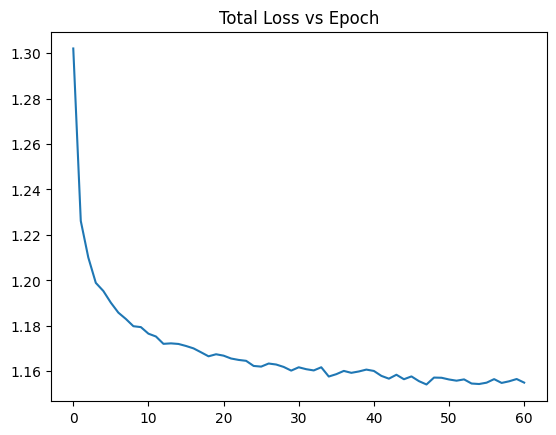

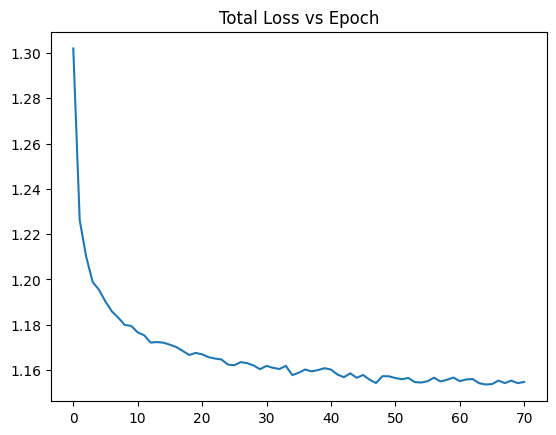

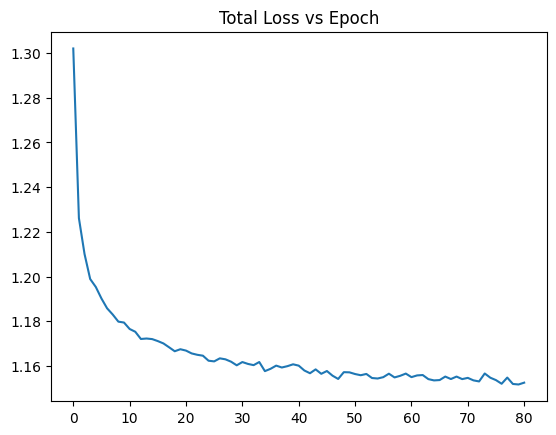

In [10]:
log_file='training_progress_style.txt'
def show_msg(msg, file=log_file):
    if file is not None:
        with open(file, 'a') as f:
            f.write(msg+"\n")
    print(msg)
open(log_file, 'w').close()

training_steps = 0
list_total_loss = []
model.train()
x_style = torch.zeros((batch_size,3,height,height))
x_style[:] = dataset.getStyle()
x_style = x_style.to(device)
for epoch in range(n_epoch):
    show_msg("------------------------------------ epoch {:03d} ({} steps) ------------------------------------".format(epoch + 1, training_steps))
    # linearly decay learning rate
    #optimizer.param_groups[0]['lr'] = learning_rate*(1-(epoch/n_epoch))
    total_loss = 0
    loss_list = []
    for x_0 in dataloader:   # x_0: images
        optimizer.zero_grad()
        x_0 = x_0.to(device)
        # perturb data
        noise = torch.randn_like(x_0).to(device)
        t = torch.randint(1, (timesteps//2) + 1, (x_0.shape[0],)).to(device)
        x_t = df.noise_image(x_0, t, noise).to(device)
        # use network to recover noise
        pred_noise = model(x_t, t / timesteps, x_style)

        # loss is measures the element-wise mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise) + 0.6*F.mse_loss(df.denoise_image(x_t, t, pred_noise), x_style)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        training_steps+=1
        #if (training_steps%100) == 0:
        #    show_msg("Total train step: {}, Loss: {}".format(training_steps,loss))
    loss_list_ = np.array(loss_list)
    show_msg("Max loss: {}".format(loss_list_.max()))
    show_msg("Min loss: {}".format(loss_list_.min()))
    total_loss = loss_list_.sum()
    list_total_loss.append(loss_list_.mean())
    show_msg("Mean loss: {}".format(loss_list_.mean()))
    show_msg("Std loss: {}".format(loss_list_.std()))
    show_msg("Total Loss: {}".format(total_loss))
    # save model periodically
    if epoch%10==0 or epoch == int(n_epoch-1):
        torch.save(model.state_dict(), save_dir + "model_style_{:03d}.pth".format(epoch + 1))
        show_msg('saved model at ' + save_dir + "model_style_{:03d}.pth".format(epoch + 1))
        plt.figure()
        plt.plot(list_total_loss)
        plt.title("Total Loss vs Epoch")
        plt.savefig('train_style.png')

# Sampling

In [11]:
model = Unet(in_channels=3, n_feat=n_feat, height=height).to(device)
model.load_state_dict(torch.load(save_dir+"model_style_081.pth", map_location=device))
model.eval()
print('')

/tmp/ipykernel_662075/563176581.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


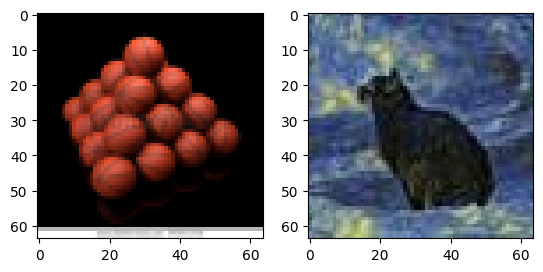

In [12]:
img = dataset[20]
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(df.unorm(img.permute(1,2,0)))
plt.subplot(1, 2, 2)
plt.imshow(df.unorm(dataset.getStyle().permute(1,2,0)))

In [21]:
imgs = (dataset[10])#, dataset[20], dataset[70], dataset[150], dataset[400]]
imgs = df.noise_image(imgs,timesteps//2)
x_style = torch.zeros_like(imgs)
x_style[:] = dataset.getStyle()
x_style = x_style.to(device)
samples = df.sample_ddpm_context(model, 1, x_style, end_timestep=timesteps//2,samples = imgs).cpu()

plt.figure(figsize=(len(imgs)*2, 10))
for i, img in enumerate(imgs):
    img_low = resize(img, (64,64)).permute(1,2,0).cpu().numpy()
    img = img.permute(1,2,0).cpu().numpy()
    plt.subplot(2, len(imgs), i+1)
    plt.imshow(df.unorm(img))
for i, img in enumerate(samples):
    img = img.permute(1,2,0).cpu().numpy()
    plt.subplot(2, len(imgs), 1*len(imgs)+i+1)
    plt.imshow(df.unorm(img))

RuntimeError: Given groups=1, weight of size [64, 6, 3, 3], expected input[1, 3, 128, 64] to have 6 channels, but got 3 channels instead

In [6]:
img = Image.open("style_.jpg")
img = img.resize((height,height))
img.save('style_.jpg')